In [0]:
import pandas as pd
from pandas import Series, DataFrame, Panel
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import sklearn
from PIL import Image
%matplotlib inline

In [2]:
# Загружаем MNIST
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')
print(X.shape)

(70000, 1, 28, 28)


In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

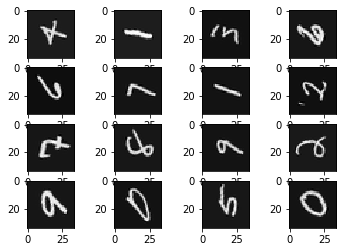

In [4]:
import scipy
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = scipy.ndimage.rotate(X[np.random.randint(0, X.shape[0]),0], 75)
    #print(I.shape)
    plt.imshow(I, cmap='gray')
#(X[np.random.randint(0, X.shape[0]),0])

In [5]:
from sklearn.preprocessing import OneHotEncoder

Y = mnist['target'].astype('int')
print('original', Y)
Y_enc = np.zeros((len(Y), 10))
for i in range(len(Y)):
  Y_enc[i, Y[i]] = 1
Y_enc

original [5 0 4 ... 4 5 6]


array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.autograd import Variable

class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        self.net = nn.Sequential()
        self.net.add_module('conv_1', nn.Conv2d(1, 32, kernel_size=(3,3), stride=1))
        self.net.add_module('relu_1', nn.ReLU())
        self.net.add_module('conv_2', nn.Conv2d(32, 64, kernel_size=(3,3), stride=1)) 
        self.net.add_module('relu_2', nn.ReLU())
        self.net.add_module('drop_1', nn.Dropout(0.1))                  
        self.fc1 = nn.Linear(64*24*24, 128)
        self.drop2 = nn.Dropout()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.net(x)
        x = x.view(-1, 64 * 24 * 24)
        x = self.fc2(self.drop2(self.fc1(x)))
        x = F.relu(x)
        return x


class MLPNet(nn.Module):

    def __init__(self):
        super(MLPNet, self).__init__()
        self.net = nn.Sequential()                 
        self.fc1 = nn.Linear(28*28, 200)
        self.drop2 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = self.net(x)
        x = x.view(-1, 28*28)
        x = self.fc2(self.drop2(self.fc1(x)))
        x = F.relu(x)
        return x


## Функция обучения модели

In [0]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss

def fit_net(c_epoch, net, X, Y):
    loss_fn = torch.nn.CrossEntropyLoss()

    learning_rate = 1e-4
    batch_size = 30
    # Оптимизатор
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    loss_curve = []
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    net = net.to(torch.device(DEVICE))
    net = net.train()
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X_train.shape[0])
        loss_acc = 0
        nbatches = X_train.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = Variable(torch.Tensor(X_train[batch_idxs]).to(DEVICE))
            y = Variable(torch.from_numpy(Y_train[batch_idxs]).long().to(DEVICE))
            y_pred = net(x)
            loss = loss_fn(y_pred, y)
            loss_acc += float(loss.data)
            optimizer.zero_grad()        
            loss.backward()
            optimizer.step()    
        avg_epoch_loss = loss_acc / (nbatches)
        print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
        loss_curve.append(avg_epoch_loss)
    net = net.eval()
    return net

def experiment_vanilla(net, X, Y, rotate=False, translate=False, blur=False):

    batch_size = 30
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    net = net.to(torch.device(DEVICE))
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)
    acc = []
    brier = []
    for iter in range(12):
        Xperm = np.random.permutation(X_test.shape[0])
        loss_acc = 0
        br = []
        nbatches = X_test.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = []
            if rotate:
                x = torch.Tensor(scipy.ndimage.rotate(X_test[batch_idxs], 15*iter, axes=(2,3)))
                x = Variable(x[:,:, int(x.shape[2]/2 - 14) : int(x.shape[2]/2 + 14), int(x.shape[3]/2 - 14) : int(x.shape[2]/2 + 14) ].to(DEVICE))
            if translate:
                x = Variable(torch.Tensor(np.roll(X_test[batch_idxs], axis=(2,3), shift=2*iter)).to(DEVICE))
            if blur:
                x = Variable(torch.Tensor(scipy.ndimage.filters.gaussian_filter(X_test[batch_idxs], sigma=iter*0.1)).to(DEVICE))
         #   print(x.shape)
            y = Y_test[batch_idxs]
            y_pred = net(x).cpu().detach().numpy()
            loss_acc += np.count_nonzero(y == np.argmax(y_pred, axis=1))
            y_enc = np.zeros((len(y), 10))
            for i in range(len(y)):
              y_enc[i, y[i]] = 1
            br += [brier_score_loss(y_enc[i], scipy.special.softmax(y_pred[i]))*10 for i in range(batch_size)]
        loss_acc /= len(Y_test)
        brier.append(np.mean(np.array(br)))
        acc.append(loss_acc)

    return acc, brier
#plt.plot(loss_curve)

In [0]:
def experiment_ensemble(nets, X, Y, rotate=False, translate=False, blur=False):

    batch_size = 30
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    for i in range(len(nets)):
        nets[i] = nets[i].to(torch.device(DEVICE))
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)
    acc = []
    brier = []
    for iter in range(12):
        Xperm = np.random.permutation(X_test.shape[0])
        loss_acc = 0
        br = []
        nbatches = X_test.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = []
            if rotate:
                x = torch.Tensor(scipy.ndimage.rotate(X_test[batch_idxs], 15*iter, axes=(2,3)))
                x = Variable(x[:,:, int(x.shape[2]/2 - 14) : int(x.shape[2]/2 + 14), int(x.shape[3]/2 - 14) : int(x.shape[2]/2 + 14) ].to(DEVICE))
            if translate:
                x = Variable(torch.Tensor(np.roll(X_test[batch_idxs], axis=(2,3), shift=2*iter)).to(DEVICE))
            if blur:
                x = Variable(torch.Tensor(scipy.ndimage.filters.gaussian_filter(X_test[batch_idxs], sigma=iter*0.1)).to(DEVICE))
         #   print(x.shape)
            y = Y_test[batch_idxs]
            y_pred = np.zeros((batch_size, 10))
            for net in nets:
                y_pred += net(x).cpu().detach().numpy()
            y_pred /= len(nets)

            loss_acc += np.count_nonzero(y == np.argmax(y_pred, axis=1))
            y_enc = np.zeros((len(y), 10))
            for i in range(len(y)):
              y_enc[i, y[i]] = 1
            br += [brier_score_loss(y_enc[i], scipy.special.softmax(y_pred[i]))*10 for i in range(batch_size)]
        loss_acc /= len(Y_test)
        brier.append(np.mean(np.array(br)))
        acc.append(loss_acc)

    return acc, brier
#plt.plot(loss_curve)

### Обучаем модели


In [9]:
   
net = LeNet()
model = fit_net(10, net, X, Y)
loss_curve_translate_vanilla , brier_curve_translate_vanilla = experiment_vanilla(model, X,Y, translate=True)
loss_curve_rotate_vanilla , brier_curve_rotate_vanilla = experiment_vanilla(model, X,Y, rotate=True)
loss_curve_blur_vanilla , brier_curve_blur_vanilla = experiment_vanilla(model, X,Y, blur=True)

Do epoch 0 with loss 0.9634398013687558
Do epoch 1 with loss 0.06958084852040061
Do epoch 2 with loss 0.03886590121786641
Do epoch 3 with loss 0.026842736364932167
Do epoch 4 with loss 0.021321724001247724
Do epoch 5 with loss 0.016584688438406804
Do epoch 6 with loss 0.01553014326641491
Do epoch 7 with loss 0.01211932959470907
Do epoch 8 with loss 0.010285178829192151
Do epoch 9 with loss 0.011057150573930497


In [10]:
nets = []
for i in range(10):
    net = LeNet()
    nets.append(fit_net(10, net, X, Y))
loss_curve_translate_ensemble , brier_curve_translate_ensemble = experiment_ensemble(nets, X,Y, translate=True)
loss_curve_rotate_ensemble , brier_curve_rotate_ensemble = experiment_ensemble(nets, X,Y, rotate=True)
loss_curve_blur_ensemble , brier_curve_blur_ensemble = experiment_ensemble(nets, X,Y, blur=True)

Do epoch 0 with loss 2.122353344518863
Do epoch 1 with loss 0.10709027751080771
Do epoch 2 with loss 0.04791887699141042
Do epoch 3 with loss 0.029936309445767206
Do epoch 4 with loss 0.02305933020895183
Do epoch 5 with loss 0.015587144169122958
Do epoch 6 with loss 0.014376823514668378
Do epoch 7 with loss 0.012704204572126659
Do epoch 8 with loss 0.00981669539328646
Do epoch 9 with loss 0.01061361207652541
Do epoch 0 with loss 1.630411296150705
Do epoch 1 with loss 0.0918507447147859
Do epoch 2 with loss 0.04998422662043938
Do epoch 3 with loss 0.03302085819303634
Do epoch 4 with loss 0.025341255424893953
Do epoch 5 with loss 0.021495032150599717
Do epoch 6 with loss 0.016180515611743714
Do epoch 7 with loss 0.015835859185345528
Do epoch 8 with loss 0.013361820020099993
Do epoch 9 with loss 0.01190999498766305
Do epoch 0 with loss 0.8474687965423825
Do epoch 1 with loss 0.07742930541377357
Do epoch 2 with loss 0.043451767046592565
Do epoch 3 with loss 0.03296162757816664
Do epoch 4 w

 ## Результаты

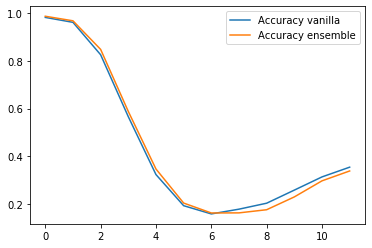

In [11]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_rotate_vanilla,label="Accuracy vanilla")
ax.plot(loss_curve_rotate_ensemble,label="Accuracy ensemble")
ax.legend()
plt.show()

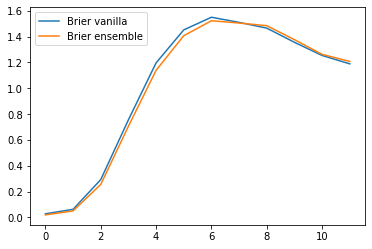

In [12]:
ax = plt.subplot(1,1,1)
ax.plot(brier_curve_rotate_vanilla,label="Brier vanilla")
ax.plot(brier_curve_rotate_ensemble,label="Brier ensemble")
ax.legend()
plt.show()

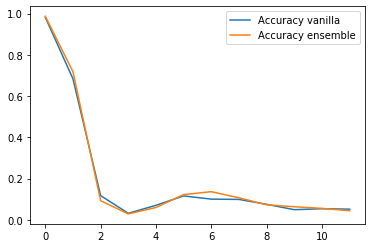

In [13]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_translate_vanilla,label="Accuracy vanilla")
ax.plot(loss_curve_translate_ensemble,label="Accuracy ensemble")
ax.legend()
plt.show()

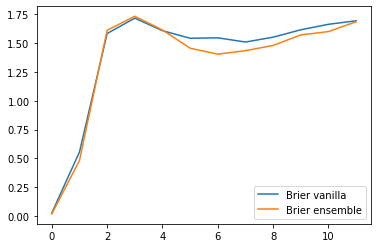

In [14]:
ax = plt.subplot(1,1,1)
ax.plot(brier_curve_translate_vanilla,label="Brier vanilla")
ax.plot(brier_curve_translate_ensemble,label="Brier ensemble")
ax.legend()
plt.show()

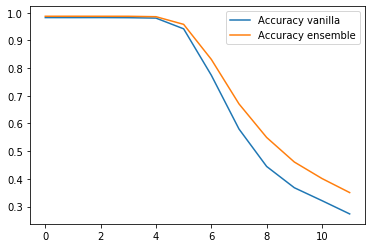

In [15]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_blur_vanilla,label="Accuracy vanilla")
ax.plot(loss_curve_blur_ensemble,label="Accuracy ensemble")
ax.legend()
plt.show()

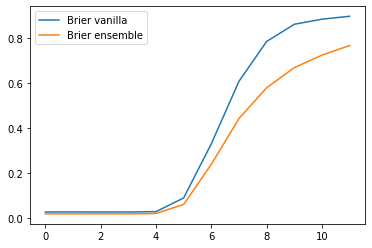

In [16]:
ax = plt.subplot(1,1,1)
ax.plot(brier_curve_blur_vanilla,label="Brier vanilla")
ax.plot(brier_curve_blur_ensemble,label="Brier ensemble")
ax.legend()
plt.show()